<a href="https://colab.research.google.com/github/FerdiWeber/Allergy-Symptom-Analysis/blob/main/OpenEarable_oe_File_Parsing_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenEarable - *.oe File Parsing Notebook
This simple notebook parses the binary file format used by [OpenEarable](openearable.com).

Just upload your files and run the cells below.

**⚠️ Please Note:** This parsing notebook was updated on November 2nd to support the more efficient *.oe file format version 2. (Firmware version 2.2.X)

# Parse the *.oe File

### Mount Goofle Drive Dat access


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper Methods

In [20]:
import struct
import os
import tempfile
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Audio
from scipy.io.wavfile import write
from scipy.signal import butter, filtfilt, resample, stft, istft
from scipy.stats import linregress
from sklearn.decomposition import PCA


LABELS = {
    "imu": ['acc.x', 'acc.y', 'acc.z', 'gyro.x', 'gyro.y', 'gyro.z', 'mag.x', 'mag.y', 'mag.z'],
    "barometer": ['barometer.temperature', 'barometer.pressure'],
    "ppg": ['ppg.red', 'ppg.ir', 'ppg.green', 'ppg.ambient'],
    "bone_acc": ['bone_acc.x', 'bone_acc.y', 'bone_acc.z'],
    "optical_temp": ['optical_temp'] # Added optical_temp label
}

COLORS = {
    "ppg": ['red', 'darkred', 'green', 'gray']
}

class SensorAccessor:
    def __init__(self, df: pd.DataFrame, labels: list):
        self._df = df
        self._data = {}
        groups = defaultdict(list)

        for label in labels:
            parts = label.split('.')
            if len(parts) == 2:
                group, field = parts
                if label in df:
                    groups[group].append(label)
            else:
                if label in df:
                    self._data[label] = df[label]

        for group, columns in groups.items():
            short_names = [label.split('.')[1] for label in columns]
            subdf = df[columns].copy()
            subdf.columns = short_names
            self._data[group] = subdf

        self._full_df = pd.concat(self._data.values(), axis=1) if self._data else df

    def __getitem__(self, key):
        return self._data.get(key, None)

    def __getattr__(self, name):
        if name in self._data:
            return self._data[name]
        if hasattr(self._full_df, name):
            return getattr(self._full_df, name)
        raise AttributeError(f"'SensorAccessor' object has no attribute '{name}'")

    def __repr__(self):
        return repr(self._full_df)

    def __getattr__df__(self):
        return self._full_df

    def to_dataframe(self):
        return self._full_df



class SensorDataset:
    SENSOR_SID = {
        "imu": 0,
        "barometer": 1,
        "microphone": 2,
        "ppg": 4,
        "optical_temp": 6,
        "bone_acc": 7,
    }

    sensor_formats = {
        SENSOR_SID["imu"]: '<9f',
        SENSOR_SID["barometer"]: '<2f',
        SENSOR_SID["ppg"]: '<4I',
        SENSOR_SID["optical_temp"]: '<f',
        SENSOR_SID["bone_acc"]: '<3h',
    }

    def __init__(self, filename, other_log_file=None, sync_log_file=None):
        self.filename = filename
        self.other_log_file = other_log_file
        self.sync_log_file = sync_log_file
        self.data = defaultdict(list)
        self.audio_stereo = None
        self.bone_sound = None
        self.df = pd.DataFrame()

        self.imu = SensorAccessor(pd.DataFrame(columns=LABELS['imu']), LABELS['imu'])
        self.barometer = SensorAccessor(pd.DataFrame(columns=LABELS['barometer']), LABELS['barometer'])
        self.ppg = SensorAccessor(pd.DataFrame(columns=LABELS['ppg']), LABELS['ppg'])
        self.bone_acc = SensorAccessor(pd.DataFrame(columns=LABELS['bone_acc']), LABELS['bone_acc'])
        self.optical_temp = SensorAccessor(pd.DataFrame(columns=LABELS['optical_temp']), LABELS['optical_temp']) # Initialize optical_temp accessor

        self.parse()
        self._build_accessors()

    def parse(self):
        FILE_HEADER_FORMAT = '<HQ'
        FILE_HEADER_SIZE = struct.calcsize(FILE_HEADER_FORMAT)
        mic_samples = []
        _sid = None

        with open(self.filename, 'rb') as f:
            version, timestamp = struct.unpack(FILE_HEADER_FORMAT, f.read(FILE_HEADER_SIZE))
            print(f"📂 File: {os.path.basename(self.filename)}, Version: {version}, Timestamp (since boot): {timestamp}µs")

            while True:
                header = f.read(10)
                if len(header) < 10:
                    break
                sid, size, time = struct.unpack('<BBQ', header)
                if size > 192 or sid > 7:
                    if _sid != None and _sid in self.data.keys():
                        self.data[_sid].pop()
                    break

                _sid = sid

                data = f.read(size)
                if len(data) < size:
                    break
                timestamp_s = time / 1e6

                try:
                    if sid == self.SENSOR_SID["microphone"]:
                        samples = struct.unpack('<96h', data)
                        mic_samples.extend(samples)
                    elif version < 2 and sid == self.SENSOR_SID["bone_acc"]:
                         self.data[sid].append((timestamp_s, data))
                    elif sid in self.sensor_formats:
                        fmt = self.sensor_formats[sid]
                        expected_size = struct.calcsize(fmt)

                        if size == expected_size:
                            values = struct.unpack(fmt, data)
                            self.data[sid].append((timestamp_s, values))
                        elif(size - 2) % expected_size == 0:
                            delta = struct.unpack('<H', data[-2:])[0] / 1e6
                            data = data[:-2]
                            for n in range(len(data) // expected_size):
                                values = struct.unpack(fmt, data[n * expected_size: (n + 1) * expected_size])
                                self.data[sid].append((timestamp_s + n * delta, values))
                        else:
                            print(f"❌ Could not parse SID {sid} at timestamp {timestamp_s}")
                            continue
                    else:
                        continue
                except struct.error:
                    print(f"❌ Could not parse SID {sid} at timestamp {timestamp_s}")

        if mic_samples:
            mic_array = np.array(mic_samples, dtype=np.int16)
            self.audio_stereo = np.column_stack((mic_array[1::2], mic_array[0::2]))  # [inner, outer] correctly

        if version < 2 and len(self.data[7]) > 0:
            all_samples = []
            sample_counts = []

            for _, d in self.data[7]:
                samples_per_packet = len(d) // struct.calcsize('<3h')
                sample_counts.append(samples_per_packet)

                for i in range(samples_per_packet):
                    offset = i * struct.calcsize('<3h')
                    sample = struct.unpack('<3h', d[offset:offset + struct.calcsize('<3h')])
                    all_samples.append(sample)

            int16_arrays = np.array(all_samples)

            detailed_times = []

            for i in range(len(self.data[7])-1):
                current_time = self.data[7][i][0]
                next_time = self.data[7][i+1][0]
                samples_in_packet = sample_counts[i]
                if samples_in_packet > 0:
                    time_diff = (next_time - current_time) / samples_in_packet
                    detailed_times.extend([current_time + j * time_diff for j in range(samples_in_packet)])
                else:
                     detailed_times.extend([current_time] * samples_in_packet)


            if len(self.data[7]) > 0:
                last_time = self.data[7][-1][0]
                last_samples = sample_counts[-1]
                if len(self.data[7]) > 1:
                    last_diff = self.data[7][-1][0] - self.data[7][-2][0]
                    if last_samples > 0:
                         detailed_times.extend([last_time + j * (last_diff/last_samples) for j in range(last_samples)])
                    else:
                         detailed_times.extend([last_time] * last_samples)

                else:
                    detailed_times.extend([last_time + j * 0.001 for j in range(last_samples)])


            self.data[7] = list(zip(detailed_times, all_samples))


    def _build_accessors(self):
        dfs = []
        for name, sid in self.SENSOR_SID.items():
            labels = LABELS.get(name, [f"val{i}" for i in range(0)])
            if sid in self.data and self.data[sid]:
                times, values = zip(*self.data[sid])
                df = pd.DataFrame(values, columns=labels)
                df['timestamp'] = times
                df.set_index('timestamp', inplace=True)
                df = df[~df.index.duplicated(keep='first')] # Drop duplicate timestamps
                dfs.append(df)
            else:
                df = pd.DataFrame(columns=labels)

            setattr(self, name, SensorAccessor(df, labels))

        if dfs:
            # Determine a common time index by taking the union of all indices and sorting
            common_index = pd.Index([])
            for df in dfs:
                common_index = common_index.union(df.index)
            common_index = common_index.sort_values()

            # Reindex each dataframe to the common index and then concatenate
            reindexed_dfs = [df.reindex(common_index) for df in dfs]
            self.df = pd.concat(reindexed_dfs, axis=1)
        else:
            self.df = pd.DataFrame()

    def get_dataframe(self):
        return self.df

    def export_csv(self):
        base_filename, _ = os.path.splitext(self.filename)
        self.save_csv(base_filename + ".csv")

    def save_csv(self, path):
        if not self.df.empty:
            self.df.to_csv(path)

    def play_audio(self, sampling_rate=48000):
        if self.audio_stereo is None:
            print("❌ No microphone data available.")
            return
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            write(tmp.name, sampling_rate, self.audio_stereo)
            display(Audio(tmp.name))

    def process_bone(self, target_sampling_rate=16000, enable_noise_reduction=True, enable_equalization=True):
        if not self.data[7]:
            print("❌ No bone sound data available.")
            return

        # Helper functions for filtering
        def butter_bandpass(lowcut, highcut, fs, order=5):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = butter(order, [low, high], btype='band')
            return b, a

        def band_pass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = filtfilt(b, a, data, axis=0)
            return y

        time_stamps = np.array([item[0] for item in self.data[7]])
        bone_sound = np.array([item[1] for item in self.data[7]])

        # Based on the provided bone sound data
        original_samplerate = 1 / np.median(np.diff(time_stamps))

        # Apply band-pass filter to the bone sound
        lowcut_frequency = 150
        highcut_frequency = 400
        filtered_signal = band_pass_filter(bone_sound, lowcut_frequency, highcut_frequency, original_samplerate)

        # Perform PCA on the filtered signal
        pca = PCA(n_components=1)  # Reduce to 1 principal component
        pca_result = pca.fit_transform(filtered_signal)

        # Project the filtered signal along the first principal component
        processed_signal = pca_result[:, 0]

        # Resample the projected signal to target sampling rate
        num_samples_target = int(len(processed_signal) * (target_sampling_rate / original_samplerate))
        resampled_signal = resample(processed_signal, num_samples_target)
        current_samplerate = target_sampling_rate

        if enable_noise_reduction:
            # Parameter for STFT
            n_fft = 2048
            hop_length = n_fft // 8

            # STFT of the signal
            frequencies, times_stft, Zxx = stft(resampled_signal, fs=current_samplerate, nperseg=n_fft, noverlap=n_fft - hop_length)

            # Extract magnitudes and phases
            magnitude = np.abs(Zxx)
            phase = np.angle(Zxx)

            # Automatic Noise Estimation
            frame_energy = np.sum(magnitude**2, axis=0)
            noise_segment_length = int(current_samplerate * 0.5 / (n_fft / hop_length))
            min_energy_index = np.argmin(frame_energy)
            start_index = max(0, min_energy_index - noise_segment_length // 2)
            end_index = min(magnitude.shape[1], start_index + noise_segment_length)
            if end_index - start_index < noise_segment_length:
                start_index = max(0, end_index - noise_segment_length)

            noise_estimation_segment = magnitude[:, start_index:end_index]
            noise_estimation = np.mean(noise_estimation_segment, axis=1, keepdims=True)

            # Spectral Subtraction
            magnitude_denoised = np.maximum(magnitude - noise_estimation, 0)

            # Reconstruction of the signal
            Zxx_denoised = magnitude_denoised * np.exp(1j * phase)
            _, denoised_signal = istft(Zxx_denoised, fs=current_samplerate, nperseg=n_fft, noverlap=n_fft - hop_length)

            # Ensure the denoised signal has the same length as the resampled signal
            processed_signal = denoised_signal[:len(resampled_signal)]


        if enable_equalization:
            # Apply peaking EQ filters at 110Hz and 220Hz with -4dB reduction
            Q = 2
            gain = 10**(-4/20) # -4dB reduction
            w0_110 = 2 * np.pi * 110 / current_samplerate
            w0_220 = 2 * np.pi * 220 / current_samplerate
            alpha_110 = np.sin(w0_110)/(2*Q)
            alpha_220 = np.sin(w0_220)/(2*Q)

            # 110Hz filter coefficients
            a0_110 = 1 + alpha_110/gain
            a1_110 = -2 * np.cos(w0_110)
            a2_110 = 1 - alpha_110/gain
            b0_110 = 1 + alpha_110*gain
            b1_110 = -2 * np.cos(w0_110)
            b2_110 = 1 - alpha_110*gain

            # 220Hz filter coefficients
            a0_220 = 1 + alpha_220/gain
            a1_220 = -2 * np.cos(w0_220)
            a2_220 = 1 - alpha_220/gain
            b0_220 = 1 + alpha_220*gain
            b1_220 = -2 * np.cos(w0_220)
            b2_220 = 1 - alpha_220*gain

            # Apply filters
            equalized_signal = filtfilt([b0_110, b1_110, b2_110], [a0_110, a1_110, a2_110], processed_signal)
            processed_signal = filtfilt([b0_220, b1_220, b2_220], [a0_220, a1_220, a2_220], equalized_signal)


        # Scale the final processed signal for playback
        self.bone_sound = np.int16(processed_signal / np.max(np.abs(processed_signal)) * 32767)

        # To play the scaled_processed_signal:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            write(tmp.name, target_sampling_rate, self.bone_sound)
            display(Audio(tmp.name))


    def plot(self):

        fig, axes = plt.subplots(3, 3, figsize=(20, 12), sharex=False) # Adjusted for more subplots
        axes = axes.flatten()

        col_titles = ["Acc", "Gyro", "Mag", "PPG", "Barometer Temp", "Barometer Pressure", "Bone_Acc", "Mic", "Optical Temp"]
        for ax, title in zip(axes, col_titles):
            ax.set_title(title)

        if not self.df.empty:
            for axis in ['x', 'y', 'z']:
                series = self.imu.acc.get(axis)
                if series is not None:
                    axes[0].plot(series.index, series, label=f"acc.{axis}")

            for axis in ['x', 'y', 'z']:
                series = self.imu.gyro.get(axis)
                if series is not None:
                    axes[1].plot(series.index, series, label=f"gyro.{axis}")

            for axis in ['x', 'y', 'z']:
                series = self.imu.mag.get(axis)
                if series is not None:
                    axes[2].plot(series.index, series, label=f"mag.{axis}")

            for label, color in zip(LABELS['ppg'], COLORS['ppg']):
                series = getattr(self.ppg, label.split('.')[1], None)
                if series is not None:
                    axes[3].plot(series.index, series, label=label, color=color)

            temp = getattr(self.barometer, 'temperature', None)
            if temp is not None:
                axes[4].plot(temp.index, temp, label="Temperature")

            pressure = getattr(self.barometer, 'pressure', None)
            if pressure is not None:
                axes[5].plot(pressure.index, pressure, label="Pressure")

            for axis in ['x', 'y', 'z']:
                series = self.bone_acc.get(axis) # Use .get() for SensorAccessor
                if series is not None:
                    axes[6].plot(series.index, series, label=f"bone_acc.{axis}")

            optical_temp = getattr(self.optical_temp, 'optical_temp', None)
            if optical_temp is not None:
                axes[8].plot(optical_temp.index, optical_temp, label="Optical Temperature")


        if self.audio_stereo is not None:
            inner, outer = self.audio_stereo[:, 0], self.audio_stereo[:, 1]
            sample_rate = 48000
            duration = len(inner) / sample_rate
            times = np.linspace(0, duration, num=len(inner))
            axes[7].plot(times, inner, label='Mic Inner', alpha=0.7)
            axes[7].plot(times, outer, label='Mic Outer', alpha=0.7)

        #own code for plotting lines from earables log files
        if self.other_log_file and self.sync_log_file:
            df_sync = pd.read_csv(self.sync_log_file)
            df_other = pd.read_csv(self.other_log_file)

            df_sync.columns = df_sync.columns.str.strip()
            df_other.columns = df_other.columns.str.strip()

            x_sensor_sec = df_sync['DeviceTimestamp'] / 1_000_000.0
            y_app_ms = df_sync['RelativePhoneTimeMS']

            if len(x_sensor_sec) < 2:
                print("❌ Error: not enough synchronisations points avaiable")

            regression = linregress(x_sensor_sec, y_app_ms)

            slope = regression.slope
            intercept = regression.intercept
            r_value = regression.rvalue


            print(f"--- Synchronisationsmodell ---")
            print(f"Umrechnungsformel: App_ms = ({slope:.4f} * Sensor_sec) + {intercept:.4f}")
            print(f"Genauigkeit (R²): {r_value**2:.8f}")
            print("-------------------------------")

            def app_ms_to_sensor_sec(app_ms):
                return (app_ms - intercept) / slope

            def sensor_sec_to_app_ms(sensor_sec):
                return (sensor_sec * slope) + intercept


            df_other['sensor_time_sec'] = df_other['RelativeTimeMS'].apply(app_ms_to_sensor_sec)

            sensor_zero = df_sync['DeviceTimestamp'].min() / 1_000_000.0

            df_other['mic_time_sec'] = df_other['sensor_time_sec'] - sensor_zero

            starts = df_other[df_other["EventType"].str.contains("SignalFrame_Start|ActionButton_Pressed", na=False)]
            releases = df_other[df_other["EventType"].str.contains("SignalFrame_Stop|ActionButton_Released", na=False)]

            pressed_label_added = False
            for t in starts["sensor_time_sec"]:
                for ax in axes:
                    if not pressed_label_added:
                        ax.axvline(t, color="orange", linestyle="--", alpha=0.7, label="ActionButton_Pressed/Start")
                        pressed_label_added = True
                    else:
                        ax.axvline(t, color="orange", linestyle="--", alpha=0.7)

            released_label_added = False
            for t in releases["sensor_time_sec"]:
                for ax in axes:
                    if not released_label_added:
                        ax.axvline(t, color="red", linestyle=":", alpha=0.8, label="ActionButton_Released")
                        released_label_added = True
                    else:
                        ax.axvline(t, color="red", linestyle=":", alpha=0.8)


        for ax in axes:
            ax.grid(True)
            if ax.get_legend_handles_labels()[1]:
                ax.legend()

        fig.suptitle(f"Recording: {os.path.basename(self.filename)}", fontsize=14)
        plt.tight_layout()
        plt.show()

    """own method for single plotting"""
    def plot_single(self, sensor):
            """
            Plot a single sensor group in large size.
            sensor: one of ["imu.acc", "imu.gyro", "imu.mag", "ppg", "barometer.temp",
                            "barometer.pressure", "bone_acc", "optical_temp", "mic"]
            """
            plt.figure(figsize=(16,6))

            if sensor.startswith("imu."):
                group = sensor.split(".")[1]
                df = getattr(self.imu, group, None)
                if df is not None:
                    for col in df.columns:
                        plt.plot(df.index, df[col], label=f"{group}.{col}")
                plt.title(f"IMU {group.upper()}")

            elif sensor == "ppg":
                for label, color in zip(LABELS['ppg'], COLORS['ppg']):
                    col = label.split('.')[1]
                    series = getattr(self.ppg, col, None)
                    if series is not None:
                        plt.plot(series.index, series, label=label, color=color)
                plt.title("PPG Sensor")

            elif sensor == "barometer.temp":
                series = getattr(self.barometer, "temperature", None)
                if series is not None:
                    plt.plot(series.index, series, label="Temperature")
                plt.title("Barometer Temperature")

            elif sensor == "barometer.pressure":
                series = getattr(self.barometer, "pressure", None)
                if series is not None:
                    plt.plot(series.index, series, label="Pressure")
                plt.title("Barometer Pressure")

            elif sensor == "bone_acc":
                df = self.bone_acc
                for axis in ["x", "y", "z"]:
                    series = df.get(axis)
                    if series is not None:
                        plt.plot(series.index, series, label=f"bone_acc.{axis}")
                plt.title("Bone Acc")

            elif sensor == "optical_temp":
                series = getattr(self.optical_temp, "optical_temp", None)
                if series is not None:
                    plt.plot(series.index, series, label="Optical Temp")
                plt.title("Optical Temp")

            elif sensor == "mic":
                if self.audio_stereo is not None:
                    inner, outer = self.audio_stereo[:, 0], self.audio_stereo[:, 1]
                    sr = 48000
                    t = np.linspace(0, len(inner)/sr, len(inner))
                    plt.plot(t, inner, label="Mic inner", alpha=0.7)
                    plt.plot(t, outer, label="Mic outer", alpha=0.7)
                plt.title("Microphone")

            else:
                print("Unknown sensor:", sensor)
                return

            # Add logic for plotting starts and releases, excluding 'mic' sensor
            if sensor != "mic" and self.other_log_file and self.sync_log_file:
                df_sync = pd.read_csv(self.sync_log_file)
                df_other = pd.read_csv(self.other_log_file)

                df_sync.columns = df_sync.columns.str.strip()
                df_other.columns = df_other.columns.str.strip()

                x_sensor_sec = df_sync['DeviceTimestamp'] / 1_000_000.0
                y_app_ms = df_sync['RelativePhoneTimeMS']

                if len(x_sensor_sec) < 2:
                    print("❌ Error: not enough synchronisations points avaiable for single plot")
                else:
                    regression = linregress(x_sensor_sec, y_app_ms)
                    slope = regression.slope
                    intercept = regression.intercept

                    def app_ms_to_sensor_sec(app_ms):
                        return (app_ms - intercept) / slope

                    df_other['sensor_time_sec'] = df_other['RelativeTimeMS'].apply(app_ms_to_sensor_sec)

                    starts = df_other[df_other["EventType"].str.contains("SignalFrame_Start|ActionButton_Pressed", na=False)]
                    releases = df_other[df_other["EventType"].str.contains("SignalFrame_Stop|ActionButton_Released", na=False)]

                    pressed_label_added = False
                    for t in starts["sensor_time_sec"]:
                        if not pressed_label_added:
                            plt.axvline(t, color="orange", linestyle="--", alpha=0.7, label="ActionButton_Pressed/Start")
                            pressed_label_added = True
                        else:
                            plt.axvline(t, color="orange", linestyle="--", alpha=0.7)

                    released_label_added = False
                    for t in releases["sensor_time_sec"]:
                        if not released_label_added:
                            plt.axvline(t, color="red", linestyle=":", alpha=0.8, label="ActionButton_Released")
                            released_label_added = True
                        else:
                            plt.axvline(t, color="red", linestyle=":", alpha=0.8)

            plt.grid()
            plt.legend()
            plt.show()

def load_recordings(file_paths):
    return [SensorDataset(path) for path in file_paths if os.path.isfile(path)]

def display_recordings(recordings):
    for ds in recordings:
        ds.plot()
        ds.play_audio()
        print("")

# Access Sensor Channels

##### Selects for easier file access

In [21]:
import os
from google.colab import drive
import ipywidgets as widgets
from IPython.display import display

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Basis-Pfad definieren (Hier musst du einmalig den groben Pfad angeben)
# Tipp: Passe diesen Pfad an den Ordner an, wo deine Probanden liegen
base_path = "/content/drive/MyDrive/Study Files/"

print(f"Suche Dateien in: {base_path} ...")

# 3. Funktion zum Finden von Dateien (rekursiv oder flach)
def find_files(extension, search_path):
    found_files = []
    # Wir laufen durch die Verzeichnisse
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if file.endswith(extension):
                # Relativen Pfad speichern für bessere Lesbarkeit, oder absoluten
                full_path = os.path.join(root, file)
                found_files.append(full_path)
    return sorted(found_files)

# Suche nach den spezifischen Dateiendungen
oe_files = find_files('.oe', base_path)
csv_files = find_files('.csv', base_path)

if not oe_files:
    print("Keine .oe Dateien gefunden! Prüfe den base_path.")
else:
    # 4. Dropdowns erstellen
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='80%')

    dropdown_oe = widgets.Dropdown(options=oe_files, description='OE Datei:', style=style, layout=layout)
    dropdown_other = widgets.Dropdown(options=csv_files, description='Other Log:', style=style, layout=layout)
    dropdown_sync = widgets.Dropdown(options=csv_files, description='Sync Log:', style=style, layout=layout)

    # 5. Anzeigen
    display(dropdown_oe, dropdown_other, dropdown_sync)

    print("\nWähle oben die Dateien aus. Der Pfad wird automatisch gespeichert.")

Suche Dateien in: /content/drive/MyDrive/Study Files/ ...


Dropdown(description='OE Datei:', layout=Layout(width='80%'), options=('/content/drive/MyDrive/Study Files/Sen…

Dropdown(description='Other Log:', layout=Layout(width='80%'), options=('/content/drive/MyDrive/Study Files/Ph…

Dropdown(description='Sync Log:', layout=Layout(width='80%'), options=('/content/drive/MyDrive/Study Files/Pho…


Wähle oben die Dateien aus. Der Pfad wird automatisch gespeichert.


In [22]:
#this is path for local execution
#ds = SensorDataset("C:\Users\f-web\Documents\Uni\Abschlussarbeit\SensorDaten\swallow\left_swallow_step1_Swallowing_2025-11-13T13-30-34.8255911256821441.oe",
#                   "C:\Users\f-web\Documents\Uni\Abschlussarbeit\SensorDaten\swallow\swallow_step1_Swallowing_2025-11-13T13-30-34.825591other_log.csv",
#                   "C:\Users\f-web\Documents\Uni\Abschlussarbeit\SensorDaten\swallow\swallow_step1_Swallowing_2025-11-13T13-30-34.825591sync_left_log.csv")

#this is for google execution
#ds = SensorDataset("/content/drive/MyDrive/Study Files/Sensor_Files/P_Files/P_005/left/Kopie von left_P_005_step4.2_Rubontheeyes_2025-12-03T09-22-23.336143720153717.oe",
#                   "/content/drive/MyDrive/Study Files/Phone_Files/P_005/P_005_step4.2_Rubontheeyes_2025-12-03T09-22-23.336143other_log.csv",
#                   "/content/drive/MyDrive/Study Files/Phone_Files/P_005/P_005_step4.2_Rubontheeyes_2025-12-03T09-22-23.336143sync_left_log.csv")

# Zugriff auf die Auswahl aus der vorherigen Zelle
path_oe = dropdown_oe.value
path_other = dropdown_other.value
path_sync = dropdown_sync.value

print("Ausgewählte OE Datei:", path_oe)

# Dein eigentlicher Code
ds = SensorDataset(path_oe, path_other, path_sync)

Ausgewählte OE Datei: /content/drive/MyDrive/Study Files/Sensor_Files/Recording_Days/09.12.2025/left/left_P_015_step2.2_Rubontheeyes_2025-12-09T14-40-19.284734632104827.oe
📂 File: left_P_015_step2.2_Rubontheeyes_2025-12-09T14-40-19.284734632104827.oe, Version: 2, Timestamp (since boot): 632112884µs


In [23]:
ds.df.head() # full dataframe

,acc.x,acc.y,acc.z,gyro.x,gyro.y,gyro.z,mag.x,mag.y,mag.z,barometer.temperature,barometer.pressure,ppg.red,ppg.ir,ppg.green,ppg.ambient,optical_temp,bone_acc.x,bone_acc.y,bone_acc.z
632.125183,-0.660425,9.72136,-1.26816,0.594516,-0.289636,-0.068598,3098.700195,576.300049,3699.300049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632.145202,-0.660425,9.72136,-1.26816,0.480186,-0.213416,-0.053354,3096.300049,569.100037,3701.700195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632.154944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57380.0,22698.0,57710.0,275.0,NaN,NaN,NaN,NaN
632.165313,-0.660425,9.72136,-1.26816,0.426832,-0.167684,-0.083842,3098.700195,571.500000,3702.900146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632.174933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57626.0,22698.0,89480.0,276.0,NaN,NaN,NaN,NaN


In [24]:
 # IMU full dataframe
ds.imu

# Accelerometer
ds.imu.acc         # Accelerometer dataframe
ds.imu.acc["x"]    # Accelerometer X channel dataframe
ds.imu.acc["y"]    # Accelerometer Y channel dataframe
ds.imu.acc["z"]    # Accelerometer Z channel dataframe

# Gyroscope
ds.imu.gyro         # IMU Gyroscope dataframe
ds.imu.gyro["x"]    # Gyroscope X channel dataframe
ds.imu.gyro["y"]    # Gyroscope Y channel dataframe
ds.imu.gyro["z"]    # Gyroscope Z channel dataframe

# Magnetometer
ds.imu.mag          # IMU Magnetometer dataframe
ds.imu.mag["x"]     # Magnetometer X dataframe
ds.imu.mag["y"]     # Magnetometer Y dataframe
ds.imu.mag["z"]     # Magnetometer Z dataframe

# PPG full dataframe
ds.ppg
ds.ppg["red"]       # PPG red channel dataframe
ds.ppg["ir"]        # PPG ir channel
ds.ppg["green"]     # PPG green channel
ds.ppg["ambient"]   # PPG ambient channel

In [25]:
ds.ppg.head()

,red,ir,green,ambient
timestamp,,,,
632.154944,57380,22698,57710,275
632.174933,57626,22698,89480,276
632.194944,57620,22698,89271,278
632.214933,57620,22693,89270,279
632.235008,57629,22691,89256,279


In [26]:

# PPG
ds.ppg["red"]       # PPG red channel
ds.ppg["ir"]        # PPG ir channel
ds.ppg["green"]     # PPG green channel
ds.ppg["ambient"]   # PPG ambient channel

# Barometer
ds.barometer["temperature"]  # Temperature
ds.barometer["pressure"]     # Pressure

# Bone accelerometer
ds.bone_acc["x"]   # Bone conduction X
ds.bone_acc["y"]   # Bone conduction Y
ds.bone_acc["z"]   # Bone conduction Z

# Plot the Recording

--- Synchronisationsmodell ---
Umrechnungsformel: App_ms = (998.8174 * Sensor_sec) + -630920.9311
Genauigkeit (R²): 0.99975061
-------------------------------


/tmp/ipython-input-1608579608.py:498: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


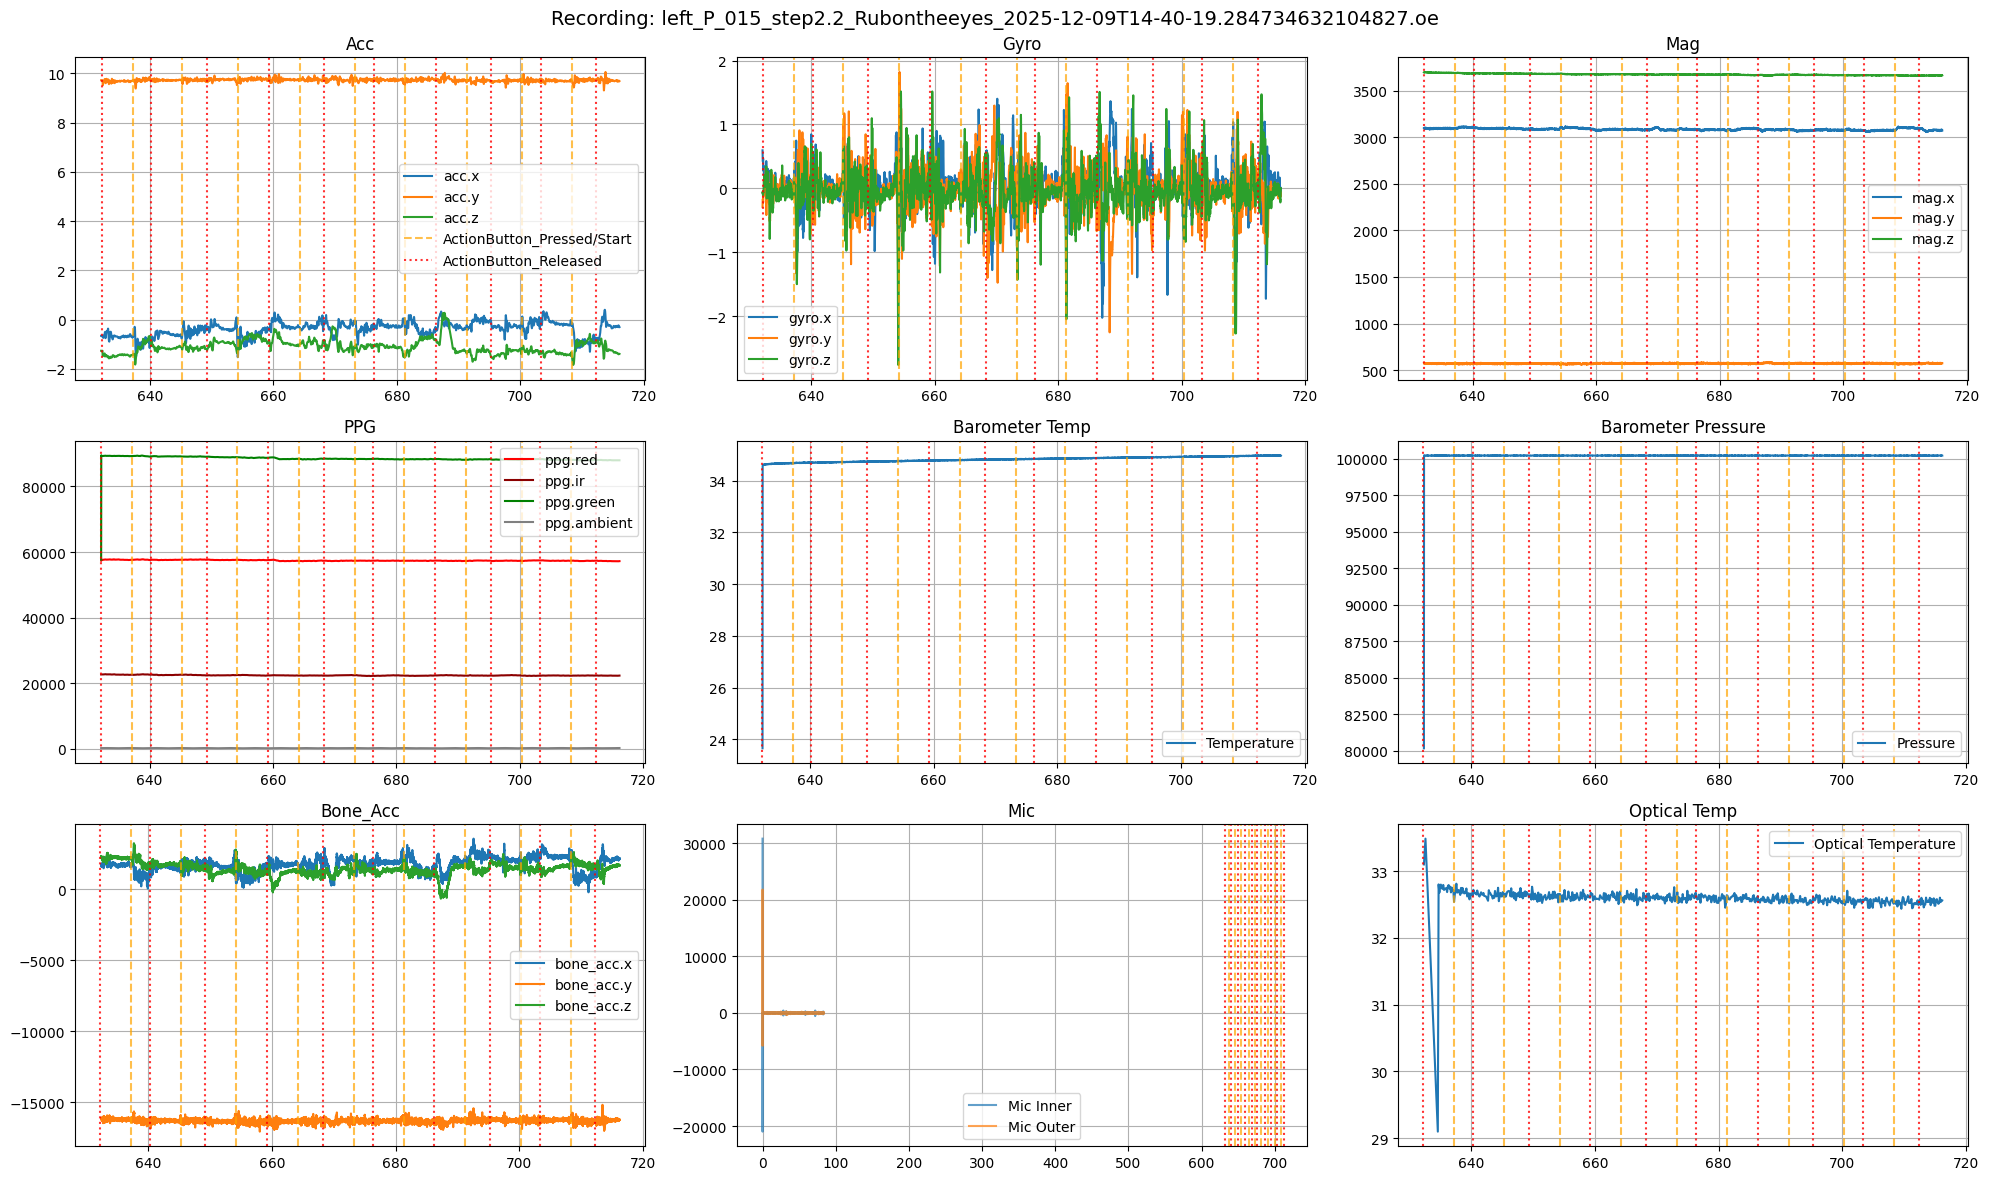

In [27]:
ds.plot()

In [29]:
import ipywidgets as widgets

sensor_options = [
    "imu.acc",
    "imu.gyro",
    "imu.mag",
    "ppg",
    "barometer.temp",
    "barometer.pressure",
    "bone_acc",
    "optical_temp",
    "mic"
]

widgets.interact(ds.plot_single, sensor=sensor_options)

interactive(children=(Dropdown(description='sensor', options=('imu.acc', 'imu.gyro', 'imu.mag', 'ppg', 'barome…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Remove Outliners
To remove outliners from the sensor files Z-Score is used. This means average and varianz are calculated. Values with greater distance than 3 times varianz to the avergae are treated as outliners and become adjusted.

In [ ]:
def clean_and_save_dataset(dataset: SensorDataset, output_folder="/content/drive/MyDrive/Training_Data", threshold=3.0):
    """
    Nimmt ein SensorDataset, entfernt Ausreißer (Z-Score) aus dem DataFrame
    und speichert das Ergebnis als Parquet-Datei.
    """

    # 1. Kopie der Daten ziehen (WICHTIG: Damit wir das Original im RAM nicht verändern)
    # dataset.df enthält bereits alle Sensoren (IMU, PPG, Baro, etc.) synchronisiert
    df_clean = dataset.get_dataframe().copy()

    if df_clean.empty:
        print(f"⚠️ Keine Daten im DataFrame für {dataset.filename} gefunden.")
        return

    print(f"🔄 Starte Bereinigung für: {os.path.basename(dataset.filename)}")

    for col in df_clean.columns:
        if not pd.api.types.is_numeric_dtype(df_clean[col]):
            continue

        mean = df_clean[col].mean()
        std = df_clean[col].std()

        if std == 0:
            continue

        # Berechnung: Wie viele Standardabweichungen ist der Wert entfernt?
        z_scores = (df_clean[col] - mean) / std

        # Maske für Ausreißer erstellen
        outlier_mask = z_scores.abs() > threshold
        n_outliers = outlier_mask.sum()

        if n_outliers > 0:

            # 3. Ausreißer entfernen (auf NaN setzen)
            df_clean.loc[outlier_mask, col] = np.nan

            # 4. Lücken füllen (Interpolation)
            # 'time' interpolation ist am genauesten, da Ihr Index Zeitstempel sind
            # limit=10 verhindert, dass riesige Lücken (z.B. Sensor-Ausfall) fantasievoll gefüllt werden
            df_clean[col] = df_clean[col].interpolate(method='linear', limit=10)

    # 5. Speichern an einem neuen Ort
    os.makedirs(output_folder, exist_ok=True)

    base_name = os.path.basename(dataset.filename)
    file_root = os.path.splitext(base_name)[0]
    save_path = os.path.join(output_folder, f"{file_root}_cleaned.parquet")

    # Als Parquet speichern (Schneller & speichereffizienter als CSV)
    # Falls Sie CSV zwingend brauchen: df_clean.to_csv(save_path.replace('.parquet', '.csv'))
    df_clean.to_parquet(save_path)

    print(f"✅ Gespeichert unter: {save_path}\n")
    return df_clean



# durch die Liste loopen:
clean_and_save_dataset(ds)

🔄 Starte Bereinigung für: Kopie von left_P_005_step4.2_Rubontheeyes_2025-12-03T09-22-23.336143720153717.oe
✅ Gespeichert unter: /content/drive/MyDrive/Training_Data/Kopie von left_P_005_step4.2_Rubontheeyes_2025-12-03T09-22-23.336143720153717_cleaned.parquet



,acc.x,acc.y,acc.z,gyro.x,gyro.y,gyro.z,mag.x,mag.y,mag.z,barometer.temperature,barometer.pressure,ppg.red,ppg.ir,ppg.green,ppg.ambient,optical_temp,bone_acc.x,bone_acc.y,bone_acc.z
720.174957,-0.014969,9.076503,4.009851,-0.205794,0.259148,-0.312502,2988.300049,326.700012,3694.500244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720.194091,-0.014969,9.076503,4.009851,-0.129574,0.198172,-0.274392,2995.500000,321.900024,3695.700195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720.20384,-0.014969,9.076503,4.009851,-0.110519,0.152440,-0.274392,2993.100098,321.900024,3695.475189,NaN,NaN,NaN,41245.0,NaN,246.0,NaN,NaN,NaN,NaN
720.214172,-0.014969,9.076503,4.009851,-0.091464,0.106708,-0.274392,2990.700195,321.900024,3695.250183,NaN,NaN,NaN,41139.0,NaN,246.5,NaN,NaN,NaN,NaN
720.223829,-0.014969,9.076503,4.009851,0.000000,0.049543,-0.297258,2993.100098,324.300018,3695.025177,NaN,NaN,NaN,41033.0,NaN,247.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804.386485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2627.0,-15515.0,-4921.0
804.387136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2624.0,-15504.0,-4908.0
804.387761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2625.0,-15503.0,-4900.0
804.388386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2628.0,-15505.0,-4899.0


from matplotlib import pyplot as plt
_df_0['acc.x'].plot(kind='hist', bins=20, title='acc.x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['acc.y'].plot(kind='hist', bins=20, title='acc.y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['acc.z'].plot(kind='hist', bins=20, title='acc.z')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['gyro.x'].plot(kind='hist', bins=20, title='gyro.x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='acc.x', y='acc.y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='acc.y', y='acc.z', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='acc.z', y='gyro.x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='gyro.x', y='gyro.y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['acc.x'].plot(kind='line', figsize=(8, 4), title='acc.x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['acc.y'].plot(kind='line', figsize=(8, 4), title='acc.y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['acc.z'].plot(kind='line', figsize=(8, 4), title='acc.z')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['gyro.x'].plot(kind='line', figsize=(8, 4), title='gyro.x')
plt.gca().spines[['top', 'right']].set_visible(False)